In [5]:
import requests
import pandas as pd
from config import tmdb_key
from pprint import pprint as pprint
import matplotlib.pyplot as plt
from calendar import month_name

In [6]:
#setting up params
base_params = dict(api_key=tmdb_key)
year = 2018
page = 1
listing_params = dict(primary_release_year=year,region='US', sort_by='revenue.desc', include_adult='false', language='en-US', page='1')
listing_params.update(base_params)
response = requests.get('https://api.themoviedb.org/3/discover/movie', params=listing_params)
imdb_films = response.json()['results']


In [7]:
# I like my charts to be dark theme, don't like the bar color the default 'dark_background' theme offers
# Skip this if you want to keep everything light
# Learned From Ashelyn Allred
plt.rcParams['axes.facecolor'] = 'xkcd:dark gray'
plt.rcParams['figure.facecolor'] = 'xkcd:dark gray'
plt.rcParams['xtick.color'] = 'xkcd:light gray'
plt.rcParams['xtick.labelcolor'] = 'xkcd:light gray'
plt.rcParams['ytick.color'] = 'xkcd:light gray'
plt.rcParams['ytick.labelcolor'] = 'xkcd:light gray'
plt.rcParams['axes.edgecolor'] = 'xkcd:gray'
plt.rcParams['axes.titlecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'xkcd:light gray'
plt.rcParams['text.color'] = 'xkcd:white'

In [8]:
#This takes approx 10-15 mins to run if you wish to cut the sample size change where it says MODIFY change 10 to a smaller number. For example "page == 2"
rows = []

restart = True
page_limit = True
while restart == True:
   while page_limit == True:
      for film in imdb_films:
         film_revenue = requests.get('https://api.themoviedb.org/3/movie/{}'.format(film['id']), params=listing_params)
         film_revenue = film_revenue.json()
         try:
            row = dict(title=film['title'], revenue=film_revenue['revenue'], Year=listing_params['primary_release_year'],\
                     VoteAVG=film['vote_average'], VoteCT=film['vote_count'], Popularity=film['popularity'], Date=film['release_date'],\
                        Genre=film['genre_ids'][0])
         except:
            pass   
         rows.append(row)
      #MODIFY page == x: to increase or decrease sample size
      if page == 10: 
         page_limit = False
      else:
         page += 1
         listing_params.update({'page':page})
         response = requests.get('https://api.themoviedb.org/3/discover/movie', params=listing_params)
         imdb_films = response.json()['results']
   if year == 2023: 
      restart = False
   else:
      page_limit = True
      page = 1
      year += 1
      listing_params.update({'primary_release_year':year})
      listing_params.update({'page':page})
      response = requests.get('https://api.themoviedb.org/3/discover/movie', params=listing_params)
      imdb_films = response.json()['results']
      
df = pd.DataFrame(rows, columns=['title', 'revenue', 'Year','VoteAVG', 'VoteCT', 'Popularity', 'Date', 'Genre'])

In [9]:
#Change data to dt and than copy to avoid later issues
df['Date'] = pd.to_datetime(df['Date'])
df_copy = df.copy()

In [10]:
#replace genre codes with recognisabled genre tags
data = pd.DataFrame(
       {
              'A': [28,12,16,35,80,99,18,10751,14,36,27,10402,9648,10749,878,10770,53,10752,37],
              'B':['Action','Adventure','Animation','Comedy','Crime','Documentary','Drama','Family','Fantasy','History',\
                     'Horror','Music','Mystery','Romance','Science', 'Fiction','TV Movie','War','Western']
       }
)
map_dict = {28:'Action', 12:'Adventure'}
map_dict = {x:data['B'].tolist()[i] for i,x in enumerate(data['A'].tolist())}
df_copy['Genre'] = df_copy['Genre'].map(map_dict)
df_copy.head()

,title,revenue,Year,VoteAVG,VoteCT,Popularity,Date,Genre
0,Avengers: Infinity War,2052415039,2018,8.3,27946,197.252,2018-04-27,Adventure
1,Black Panther,1349926083,2018,7.4,21169,62.546,2018-02-16,Action
2,Jurassic World: Fallen Kingdom,1310466296,2018,6.5,10525,57.672,2018-06-22,Action
3,Incredibles 2,1242805359,2018,7.5,12140,78.707,2018-06-15,Action
4,Aquaman,1148528393,2018,6.9,13069,54.338,2018-12-21,Action


In [11]:
#export df_copy to a csv to be read in film_analysis
df_copy.to_csv("output_data/tmdb_movies.csv", index_label="Index")

In [12]:
#Create a dataframe with film data grouped by year to do anlysis on
df_grouped = df_copy.groupby('Year')['revenue']
Mean = df_grouped.mean()
Median = df_grouped.median()
SUM = df_grouped.sum()
MAX = df_grouped.max()
VAR = df_grouped.var()
STD = df_grouped.std()
SEM = df_grouped.sem()

summary_dic = {
    'Sum': SUM,
    'Mean': Mean,
    'max': MAX,
    'Median': Median,
    'VAR': VAR,
    "STD": STD,
    'SEM': SEM
}

dfmovie_summary = pd.DataFrame(summary_dic)
dfmovie_summary

,Sum,Mean,max,Median,VAR,STD,SEM
Year,,,,,,,
2018,29805757747,1.490288e+08,2052415039,41071189.5,7.421928e+16,2.724322e+08,1.926386e+07
2019,29961648503,1.498082e+08,2800000000,38170505.5,1.039134e+17,3.223560e+08,2.279401e+07
2020,6018720886,3.009360e+07,503063688,2088769.5,6.557609e+15,8.097906e+07,5.726084e+06
2021,14685970896,7.342985e+07,1921847111,13414265.0,3.454413e+16,1.858605e+08,1.314232e+07
2022,19583301146,9.791651e+07,2320250281,14789929.0,6.314694e+16,2.512905e+08,1.776892e+07
2023,18959842138,9.479921e+07,1441700000,11250000.0,4.351922e+16,2.086126e+08,1.475114e+07


In [13]:
#create a bunch of seperate dfs to easily pull info from for charts below
movietags = ['title', 'revenue', 'Year','VoteAVG', 'VoteCT', 'Popularity', 'Date', 'Genre']
movies2018_df = df_copy.loc[df_copy['Year'] == 2018, movietags]
movies2019_df = df_copy.loc[df_copy['Year'] == 2019, movietags]
movies2020_df = df_copy.loc[df_copy['Year'] == 2020, movietags]
movies2021_df = df_copy.loc[df_copy['Year'] == 2021, movietags]
movies2022_df = df_copy.loc[df_copy['Year'] == 2022, movietags]
movies2023_df = df_copy.loc[df_copy['Year'] == 2023, movietags]

movies2018_df = movies2018_df.sort_values(by=['Date'])
MBM_2018 = movies2018_df.groupby(movies2018_df['Date'].dt.month)['revenue'].sum().reset_index()

movies2019_df = movies2019_df.sort_values(by=['Date'])
MBM_2019 = movies2019_df.groupby(movies2019_df['Date'].dt.month)['revenue'].sum().reset_index()

movies2020_df = movies2020_df.sort_values(by=['Date'])
MBM_2020 = movies2020_df.groupby(movies2020_df['Date'].dt.month)['revenue'].sum().reset_index()

movies2021_df = movies2021_df.sort_values(by=['Date'])
MBM_2021 = movies2021_df.groupby(movies2021_df['Date'].dt.month)['revenue'].sum().reset_index()

movies2022_df = movies2022_df.sort_values(by=['Date'])
MBM_2022 = movies2022_df.groupby(movies2022_df['Date'].dt.month)['revenue'].sum().reset_index()

movies2023_df = movies2023_df.sort_values(by=['Date'])
MBM_2023 = movies2023_df.groupby(movies2023_df['Date'].dt.month)['revenue'].sum().reset_index()

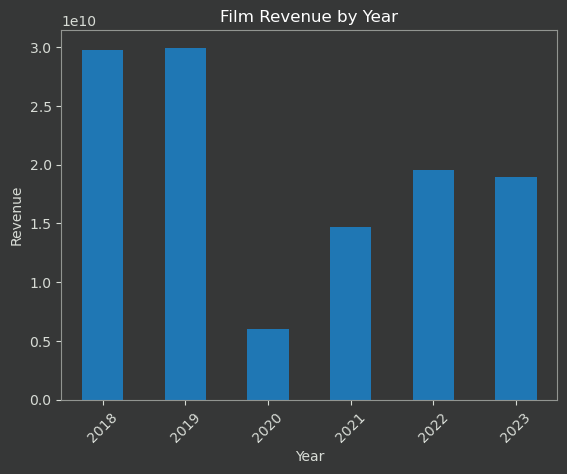

In [14]:
# Create Line chart comparing revenue across the years 2018-2023
yearly_rev = df_copy.groupby('Year')['revenue'].sum()

film_bar = yearly_rev.plot(kind='bar', title='Film Revenue by Year')
film_bar.set_ylabel('Revenue')
plt.xticks(rotation=45)

plt.savefig("output_data/Charts/01_film_rev_bar")
plt.show()

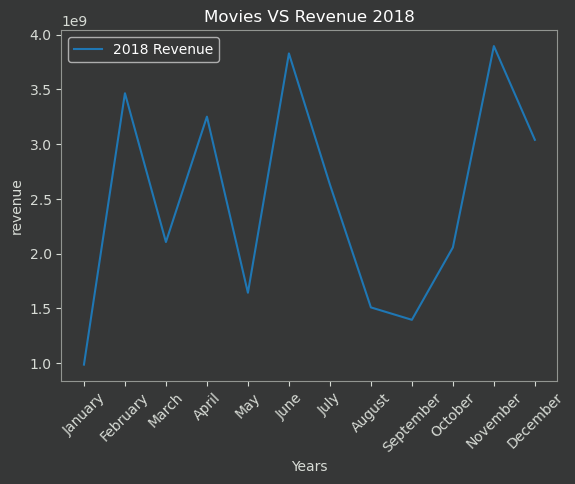

In [15]:
# Create Line chart for Movies vs Revenue for the year of 2018
plot_data = [MBM_2018['Date'].values, movies2018_df['revenue'].values, movies2018_df['Year'].unique()[0]]

plt.plot(range(1,13),MBM_2018['revenue'],label='2018 Revenue')
plt.xlabel('Years')
plt.ylabel('revenue')
plt.title(f"Movies VS Revenue {plot_data[2]}")
plt.xticks(range(1,13),[month_name[x] for x in range(1,13)],rotation=45)
plt.gcf().subplots_adjust(bottom=0.15)
plt.legend(loc="upper left")

plt.savefig("output_data/Charts/02_movies_revenue_2018")

plt.show()

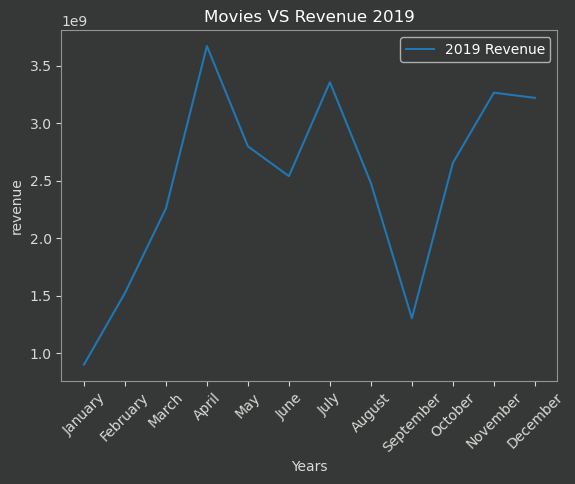

In [16]:
# Create Line chart for Movies vs Revenue for the year of 2019
plot_data = [MBM_2019['Date'].values, movies2019_df['revenue'].values, movies2019_df['Year'].unique()[0]]

plt.plot(range(1,13),MBM_2019['revenue'], label='2019 Revenue')
plt.xlabel('Years')
plt.ylabel('revenue')
plt.title(f"Movies VS Revenue {plot_data[2]}")
plt.xticks(range(1,13),[month_name[x] for x in range(1,13)],rotation=45)
plt.gcf().subplots_adjust(bottom=0.15)
plt.legend(loc="upper right")

plt.savefig("output_data/Charts/03_movies_revenue_2019")

plt.show()

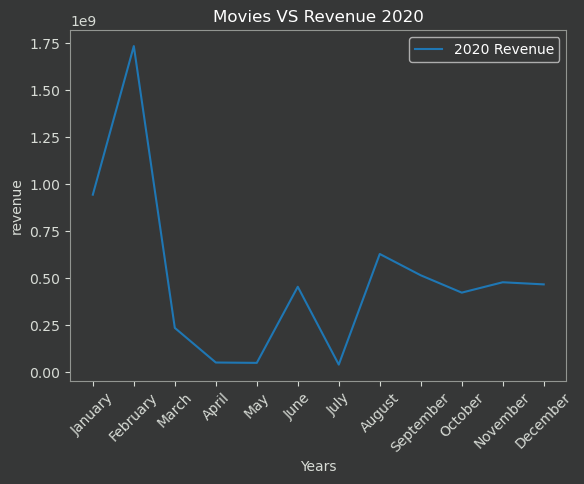

In [17]:
# Create Line chart for Movies vs Revenue for the year of 2020
plot_data = [MBM_2020['Date'].values, movies2020_df['revenue'].values, movies2020_df['Year'].unique()[0]]

plt.plot(range(1,13),MBM_2020['revenue'], label='2020 Revenue')
plt.xlabel('Years')
plt.ylabel('revenue')
plt.title(f"Movies VS Revenue {plot_data[2]}")
plt.xticks(range(1,13),[month_name[x] for x in range(1,13)],rotation=45)
plt.gcf().subplots_adjust(bottom=0.15)
plt.legend(loc="upper right")

plt.savefig("output_data/Charts/04_movies_revenue_2020")

plt.show()

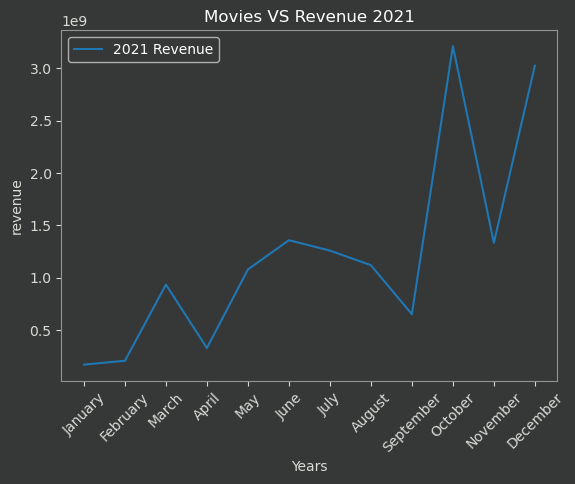

In [18]:
# Create Line chart for Movies vs Revenue for the year of 2021
plot_data = [MBM_2021['Date'].values, movies2021_df['revenue'].values, movies2021_df['Year'].unique()[0]]

plt.plot(range(1,13),MBM_2021['revenue'], label='2021 Revenue')
plt.xlabel('Years')
plt.ylabel('revenue')
plt.title(f"Movies VS Revenue {plot_data[2]}")
plt.xticks(range(1,13),[month_name[x] for x in range(1,13)],rotation=45)
plt.gcf().subplots_adjust(bottom=0.15)
plt.legend(loc="upper left")

plt.savefig("output_data/Charts/05_movies_revenue_2021")

plt.show()

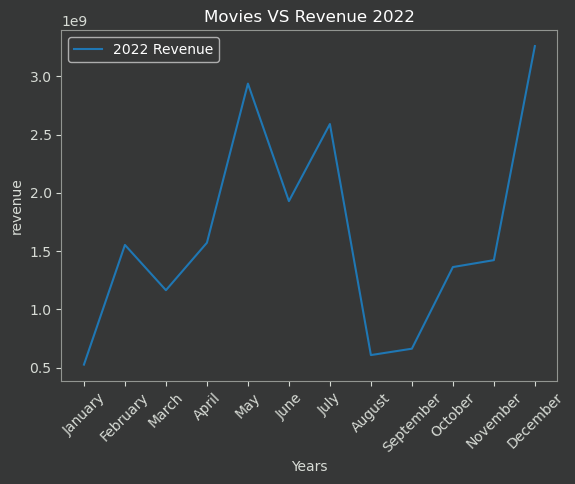

In [19]:
# Create Line chart for Movies vs Revenue for the year of 2022
plot_data = [MBM_2022['Date'].values, movies2022_df['revenue'].values, movies2022_df['Year'].unique()[0]]

plt.plot(range(1,13),MBM_2022['revenue'], label='2022 Revenue')
plt.xlabel('Years')
plt.ylabel('revenue')
plt.title(f"Movies VS Revenue {plot_data[2]}")
plt.xticks(range(1,13),[month_name[x] for x in range(1,13)],rotation=45)
plt.gcf().subplots_adjust(bottom=0.15)
plt.legend(loc="upper left")

plt.savefig("output_data/Charts/06_movies_revenue_2022")

plt.show()

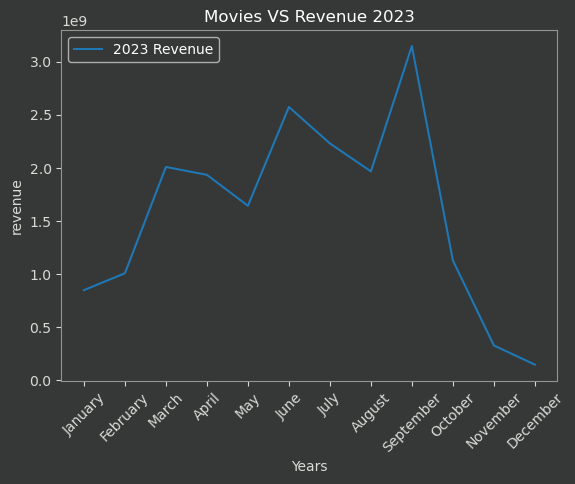

In [20]:
# Create Line chart for Movies vs Revenue for the year of 2023
plot_data = [MBM_2023['Date'].values, movies2023_df['revenue'].values, movies2023_df['Year'].unique()[0]]

plt.plot(range(1,13),MBM_2023['revenue'], label='2023 Revenue')
plt.xlabel('Years')
plt.ylabel('revenue')
plt.title(f"Movies VS Revenue {plot_data[2]}")
plt.xticks(range(1,13),[month_name[x] for x in range(1,13)],rotation=45)
plt.gcf().subplots_adjust(bottom=0.15)
plt.legend(loc="upper left")

plt.savefig("output_data/Charts/07_movies_revenue_2023")

plt.show()

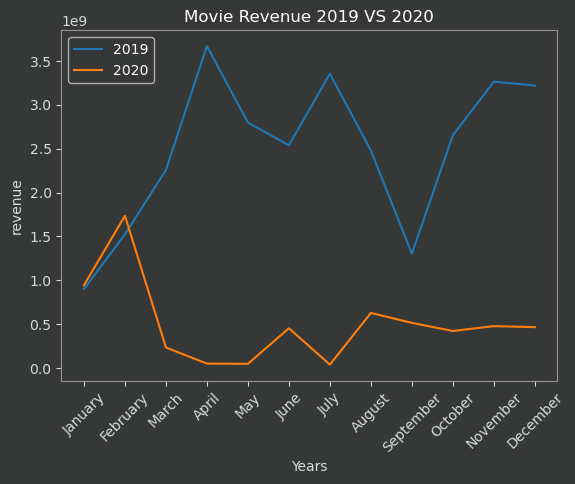

In [21]:
# Create Line chart for Movies Revenue comparing 2019 to 2020
plot_2019 = [MBM_2019['Date'].values, movies2019_df['revenue'].values, movies2019_df['Year'].unique()[0]]
plot_2020 = [MBM_2020['Date'].values, movies2020_df['revenue'].values, movies2020_df['Year'].unique()[0]]

plt.plot(range(1,13),MBM_2019['revenue'], label='2019')
plt.plot(range(1,13),MBM_2020['revenue'], label='2020')
plt.xlabel('Years')
plt.ylabel('revenue')
plt.title("Movie Revenue 2019 VS 2020")
plt.xticks(range(1,13),[month_name[x] for x in range(1,13)],rotation=45)
plt.legend(loc="upper left")

plt.gcf().subplots_adjust(bottom=0.15)

plt.savefig("output_data/Charts/08_movies_revenue_2019vs2020")

plt.show()

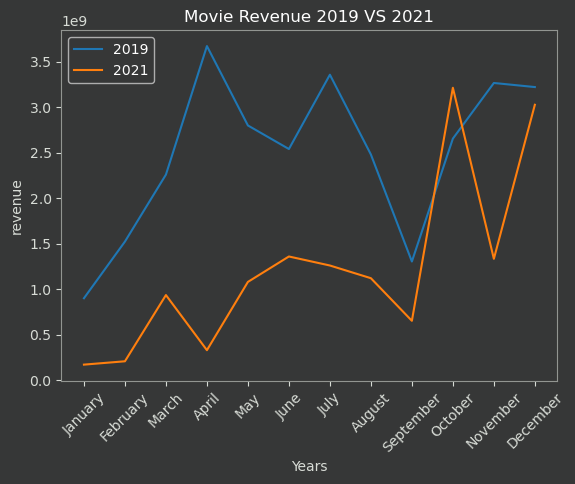

In [22]:
# Create Line chart for Movies Revenue comparing 2019 to 2021
plot_2019 = [MBM_2019['Date'].values, movies2019_df['revenue'].values, movies2019_df['Year'].unique()[0]]
plot_2021 = [MBM_2021['Date'].values, movies2021_df['revenue'].values, movies2021_df['Year'].unique()[0]]


plt.plot(range(1,13),MBM_2019['revenue'], label='2019')
plt.plot(range(1,13),MBM_2021['revenue'], label='2021')
plt.xlabel('Years')
plt.ylabel('revenue')
plt.title("Movie Revenue 2019 VS 2021")
plt.xticks(range(1,13),[month_name[x] for x in range(1,13)],rotation=45)
plt.legend(loc="upper left")

plt.gcf().subplots_adjust(bottom=0.15)

plt.savefig("output_data/Charts/09_movies_revenue_2019vs2021")

plt.show()

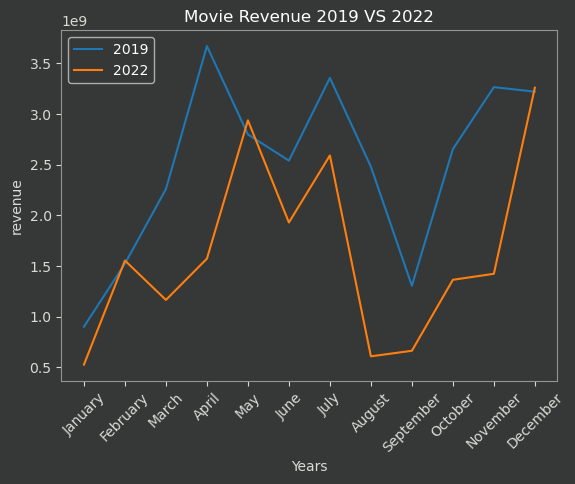

In [23]:
# Create Line chart for Movies Revenue comparing 2019 to 2022
plot_2019 = [MBM_2019['Date'].values, movies2019_df['revenue'].values, movies2019_df['Year'].unique()[0]]
plot_2022 = [MBM_2022['Date'].values, movies2022_df['revenue'].values, movies2022_df['Year'].unique()[0]]


plt.plot(range(1,13),MBM_2019['revenue'], label='2019')
plt.plot(range(1,13),MBM_2022['revenue'], label='2022')
plt.xlabel('Years')
plt.ylabel('revenue')
plt.title("Movie Revenue 2019 VS 2022")
plt.xticks(range(1,13),[month_name[x] for x in range(1,13)],rotation=45)
plt.legend(loc="upper left")

plt.gcf().subplots_adjust(bottom=0.15)

plt.savefig("output_data/Charts/10_movies_revenue_2019vs2022")

plt.show()

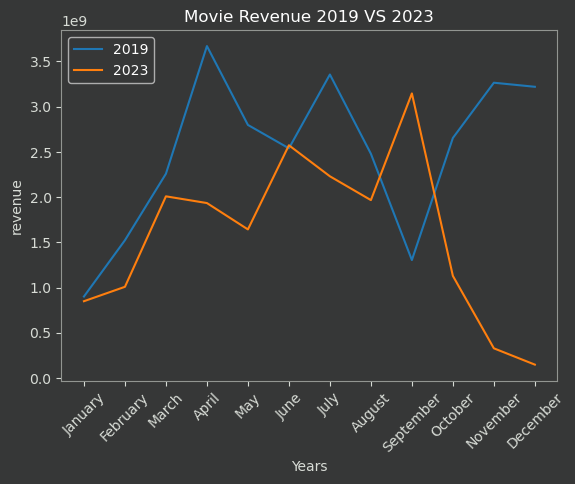

In [24]:
# Create Line chart for Movies Revenue comparing 2019 to 2023
plot_2019 = [MBM_2019['Date'].values, movies2019_df['revenue'].values, movies2019_df['Year'].unique()[0]]
plot_2023 = [MBM_2023['Date'].values, movies2023_df['revenue'].values, movies2023_df['Year'].unique()[0]]

plt.plot(range(1,13),MBM_2019['revenue'], label='2019')
plt.plot(range(1,13),MBM_2023['revenue'], label='2023')
plt.xlabel('Years')
plt.ylabel('revenue')
plt.title("Movie Revenue 2019 VS 2023")
plt.xticks(range(1,13),[month_name[x] for x in range(1,13)],rotation=45)
plt.legend(loc="upper left")

plt.gcf().subplots_adjust(bottom=0.15)

plt.savefig("output_data/Charts/11_movies_revenue_2019vs2023")

plt.show()